In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
from pathlib import Path
from datetime import datetime
from utils.env_utils import *
from utils.sim_utils import *
from utils.train_utils import *
from utils.vec_sim_utils import *
from utils.encoder_utils import *
from utils.mmd_loss import MMDLoss
from models.Generator import ModularPolicy
from models.Discriminator import Discriminator

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
window_len = 10
window_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\windows\{window_len} windows'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pred_files = []
prey_files = []

for file in os.listdir(window_path):
    if file.startswith("pred"):
        pred_tensor = torch.load(os.path.join(window_path, file))
        pred_files.append(pred_tensor)
    elif file.startswith("prey"):
        prey_tensor = torch.load(os.path.join(window_path, file))
        prey_files.append(prey_tensor)

exp_pred_tensor = torch.cat(pred_files, dim=0).type(torch.float32)
exp_prey_tensor = torch.cat(prey_files, dim=0).type(torch.float32)

print("Pred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)


init_pool_path = rf"..\data\1. Data Processing\processed\init_pool\init_pool.pt"
init_pool = torch.load(init_pool_path).to(device)

Pred Tensor Shape: torch.Size([793, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([793, 10, 32, 32, 6])


[PREDATOR]
Min: -0.9919252395629883
Max: 1.0
Mean: -0.004511773373101074


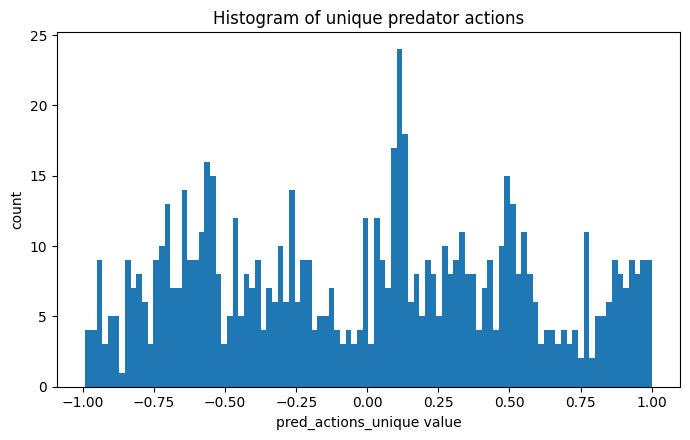

In [21]:
pred_actions = exp_pred_tensor[..., 4]
pred_actions_unique = list(set(pred_actions.reshape(-1).tolist()))
print("[PREDATOR]")
print("Min:", min(pred_actions_unique))
print("Max:", max(pred_actions_unique))
print("Mean:", sum(pred_actions_unique)/len(pred_actions_unique))

plt.figure(figsize=(7,4.5))
plt.hist(pred_actions_unique, bins=100)
plt.xlabel("pred_actions_unique value")
plt.ylabel("count")
plt.title("Histogram of unique predator actions")
plt.tight_layout()
plt.show()

[PREY]
Min: -1.0
Max: 1.0
Mean: 0.041515450359560405


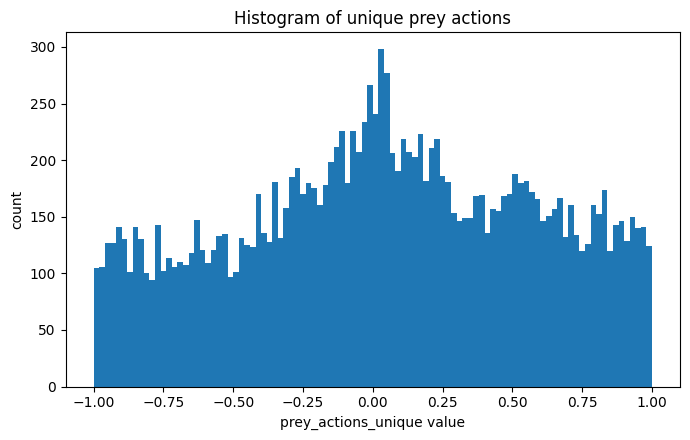

In [22]:
prey_actions = exp_prey_tensor[..., 5]
prey_actions_unique = list(set(prey_actions.reshape(-1).tolist()))

print("[PREY]")
print("Min:", min(prey_actions_unique))
print("Max:", max(prey_actions_unique))
print("Mean:", sum(prey_actions_unique)/len(prey_actions_unique))

plt.figure(figsize=(7,4.5))
plt.hist(prey_actions_unique, bins=100)
plt.xlabel("prey_actions_unique value")
plt.ylabel("count")
plt.title("Histogram of unique prey actions")
plt.tight_layout()
plt.show()

In [6]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=1200, optimizer=prey_optimizer, role="prey")#1000
torch.save(prey_encoder.state_dict(), rf"..\models\trained_policies\Encoder\prey_encoder.pt")


pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=600, optimizer=pred_optimizer, role="predator") #500
torch.save(pred_encoder.state_dict(), rf"..\models\trained_policies\Encoder\pred_encoder.pt")

epoch 010: loss=23.306984 sim=0.0519 std=1.3752 cov=0.2759 std_mean=0.312
epoch 020: loss=21.969267 sim=0.0394 std=1.2457 cov=0.4596 std_mean=0.377
epoch 030: loss=21.189587 sim=0.0326 std=1.1929 cov=0.4960 std_mean=0.404
epoch 040: loss=20.837986 sim=0.0393 std=1.1723 cov=0.4541 std_mean=0.414
epoch 050: loss=20.520903 sim=0.0407 std=1.1457 cov=0.4637 std_mean=0.427
epoch 060: loss=20.198879 sim=0.0424 std=1.1130 cov=0.4885 std_mean=0.443
epoch 070: loss=19.716877 sim=0.0413 std=1.0767 cov=0.5071 std_mean=0.462
epoch 080: loss=19.921392 sim=0.0489 std=1.0662 cov=0.5413 std_mean=0.467
epoch 090: loss=19.345362 sim=0.0455 std=1.0410 cov=0.5188 std_mean=0.479
epoch 100: loss=19.276777 sim=0.0472 std=1.0237 cov=0.5482 std_mean=0.488
epoch 110: loss=18.997063 sim=0.0496 std=1.0066 cov=0.5318 std_mean=0.497
epoch 120: loss=18.755365 sim=0.0464 std=0.9882 cov=0.5545 std_mean=0.506
epoch 130: loss=18.684881 sim=0.0530 std=0.9687 cov=0.5659 std_mean=0.516
epoch 140: loss=18.674152 sim=0.0530 s

In [7]:
def pretrain_policy(policy, role, expert_data, 
                     batch_size=256, epochs=250, 
                     lr=1e-3, deterministic=True, 
                     patience=10, device='cuda'):

    policy = policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    n, frames, agents, neigh, features = expert_data.shape
    expert_data = expert_data.reshape(n * frames * agents, neigh, features)
    
    if role == "prey":
        states  = expert_data[..., :5]
        actions = expert_data[:, 0, 5]
    else:
        states  = expert_data[..., :4]
        actions = expert_data[:, 0, 4]

    # make sure actions are float for MSE
    actions = actions.to(torch.float32)

    dataset = TensorDataset(states, actions)
    val_size = int(0.2 * len(dataset))  # 80/20 split
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    bad_epochs = 0
    train_losses = []
    val_losses = []

    best_val = float("inf")
    best_state = None

    for epoch in range(1, epochs + 1):
        # Train
        policy.train()
        epoch_train_loss = 0.0
        train_count = 0

        for states, actions in train_loader:
            states = states.to(device=device)
            exp_actions = actions.to(device=device)

            est_actions = policy.forward(states, deterministic=deterministic).squeeze(-1)
            loss = F.mse_loss(est_actions, exp_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            bs = exp_actions.size(0)
            epoch_train_loss += loss.item() * bs
            train_count += bs
            
        epoch_train_loss = epoch_train_loss / max(1, train_count)
        train_losses.append(float(epoch_train_loss))

        # Validation
        policy.eval()
        epoch_val_loss = 0.0
        val_count = 0

        with torch.no_grad():
            for states, actions in val_loader:
                states = states.to(device=device)
                exp_actions = actions.to(device=device)

                est_actions = policy.forward(states, deterministic=True).squeeze(-1)
                loss = F.mse_loss(est_actions, exp_actions)

                bs = exp_actions.size(0)
                epoch_val_loss += loss.item() * bs
                val_count += bs

        epoch_val_loss = epoch_val_loss / max(1, val_count)
        val_losses.append(float(epoch_val_loss))

        # Early stopping
        if epoch_val_loss < best_val:
            best_val = epoch_val_loss
            best_state = copy.deepcopy(policy.state_dict())
            bad_epochs = 0
        else:
            bad_epochs += 1

        if epoch % 25 == 0:
            print(f"[{role.upper()}] Epoch {epoch}/{epochs} | train_loss:{epoch_train_loss:.6f} | val_loss:{epoch_val_loss:.6f}")

        if bad_epochs >= patience:
            print(f"[{role.upper()}] Early stopping at epoch {epoch}.")
            break

    plt.figure(figsize=(7, 4))
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"[{role.upper()}] Pretrain Loss Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return policy.load_state_dict(best_state)

[PREDATOR] Epoch 25/2000 | train_loss:0.070388 | val_loss:0.066145
[PREDATOR] Epoch 50/2000 | train_loss:0.061761 | val_loss:0.057806
[PREDATOR] Epoch 75/2000 | train_loss:0.053359 | val_loss:0.048906
[PREDATOR] Epoch 100/2000 | train_loss:0.047720 | val_loss:0.043289
[PREDATOR] Epoch 125/2000 | train_loss:0.043378 | val_loss:0.039345
[PREDATOR] Epoch 150/2000 | train_loss:0.040006 | val_loss:0.035911
[PREDATOR] Epoch 175/2000 | train_loss:0.037332 | val_loss:0.033511
[PREDATOR] Epoch 200/2000 | train_loss:0.035113 | val_loss:0.031909
[PREDATOR] Epoch 225/2000 | train_loss:0.033337 | val_loss:0.030492
[PREDATOR] Epoch 250/2000 | train_loss:0.031813 | val_loss:0.029550
[PREDATOR] Epoch 275/2000 | train_loss:0.030411 | val_loss:0.028478
[PREDATOR] Epoch 300/2000 | train_loss:0.029006 | val_loss:0.027289
[PREDATOR] Epoch 325/2000 | train_loss:0.027675 | val_loss:0.026685
[PREDATOR] Epoch 350/2000 | train_loss:0.026516 | val_loss:0.025646
[PREDATOR] Epoch 375/2000 | train_loss:0.025382 | v

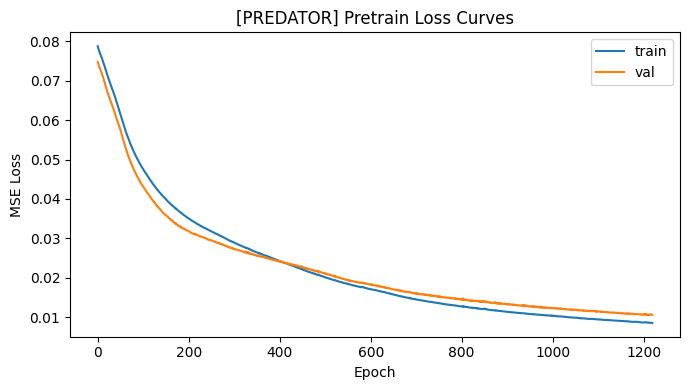

[PREY] Epoch 25/2000 | train_loss:0.057825 | val_loss:0.057666
[PREY] Epoch 50/2000 | train_loss:0.055386 | val_loss:0.055324
[PREY] Epoch 75/2000 | train_loss:0.053955 | val_loss:0.053864
[PREY] Epoch 100/2000 | train_loss:0.053062 | val_loss:0.053119
[PREY] Epoch 125/2000 | train_loss:0.052465 | val_loss:0.052677
[PREY] Epoch 150/2000 | train_loss:0.051888 | val_loss:0.051914
[PREY] Epoch 175/2000 | train_loss:0.051392 | val_loss:0.051637
[PREY] Epoch 200/2000 | train_loss:0.050862 | val_loss:0.051047
[PREY] Epoch 225/2000 | train_loss:0.050502 | val_loss:0.050746
[PREY] Epoch 250/2000 | train_loss:0.050187 | val_loss:0.050652
[PREY] Epoch 275/2000 | train_loss:0.049923 | val_loss:0.050516
[PREY] Epoch 300/2000 | train_loss:0.049684 | val_loss:0.050128
[PREY] Early stopping at epoch 305.


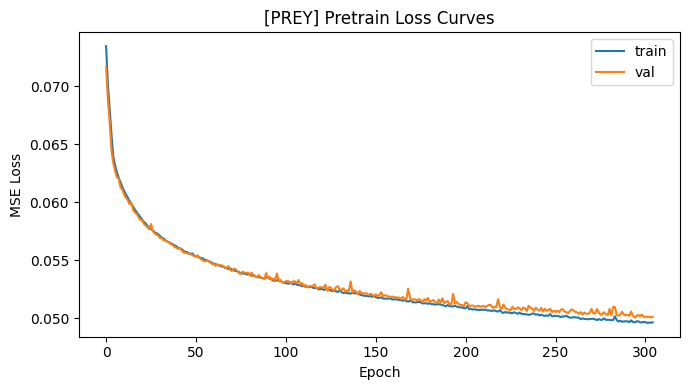

In [25]:
pred_policy = ModularPolicy(features=4).to(device)
exp_pred_tensor[..., 4] = ((exp_pred_tensor[..., 4] + 1) / 2).clamp(0.0, 1.0)
pretrain_policy(pred_policy, "predator", expert_data=exp_pred_tensor, 
                batch_size=4048, epochs=2000, lr=1e-3, patience=10,
                deterministic=True, device=device)
torch.save(pred_policy.state_dict(), rf"..\models\trained_policies\BC-Policy\bc_pred_policy.pt")


prey_policy = ModularPolicy(features=5).to(device)
exp_prey_tensor[..., 5] = ((exp_prey_tensor[..., 5] + 1) / 2).clamp(0.0, 1.0)
pretrain_policy(prey_policy, "prey", expert_data=exp_prey_tensor, 
                batch_size=4048, epochs=2000, lr=1e-3, patience=10,
                deterministic=True, device=device)
torch.save(prey_policy.state_dict(), rf"..\models\trained_policies\BC-Policy\bc_prey_policy.pt")

In [36]:
%matplotlib tk
gen_pred_tensor, gen_prey_tensor = run_env_simulation(visualization='on', 
                                        prey_policy=prey_policy, pred_policy=pred_policy,
                                        n_prey=32, n_pred=1, max_steps=100,
                                        pred_speed=5, prey_speed=5, step_size=10,
                                        area_width=2160, area_height=2160, init_pool=init_pool)

[PREDATOR]
Min: 0.002511380473151803
Max: 0.9999391436576843
Mean: 0.579891454486642


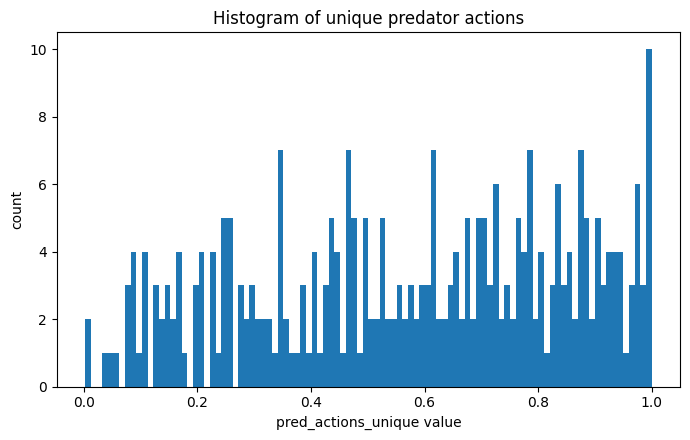

In [27]:
%matplotlib inline
pred_actions = gen_pred_tensor[..., 4]
pred_actions_unique = list(set(pred_actions.reshape(-1).tolist()))
print("[PREDATOR]")
print("Min:", min(pred_actions_unique))
print("Max:", max(pred_actions_unique))
print("Mean:", sum(pred_actions_unique)/len(pred_actions_unique))

plt.figure(figsize=(7,4.5))
plt.hist(pred_actions_unique, bins=100)
plt.xlabel("pred_actions_unique value")
plt.ylabel("count")
plt.title("Histogram of unique predator actions")
plt.tight_layout()
plt.show()

[PREY]
Min: 0.0006907025235705078
Max: 0.999435544013977
Mean: 0.5327870952446392


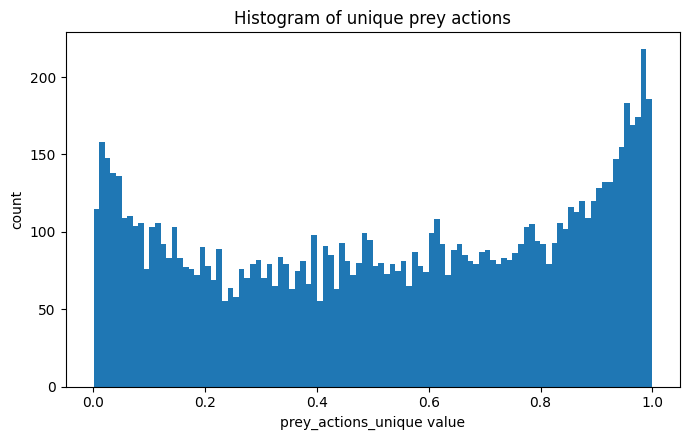

In [28]:
%matplotlib inline
prey_actions = gen_prey_tensor[..., 5]
prey_actions_unique = list(set(prey_actions.reshape(-1).tolist()))

print("[PREY]")
print("Min:", min(prey_actions_unique))
print("Max:", max(prey_actions_unique))
print("Mean:", sum(prey_actions_unique)/len(prey_actions_unique))

plt.figure(figsize=(7,4.5))
plt.hist(prey_actions_unique, bins=100)
plt.xlabel("prey_actions_unique value")
plt.ylabel("count")
plt.title("Histogram of unique prey actions")
plt.tight_layout()
plt.show()
